Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [2]:

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
data_dir_test

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
!pwd

/content


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

0
53


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123
num_classes = 9
epochs = 20

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='training',
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed = seed
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='validation',
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed = seed
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
print(f"Number of Tranning samples: {len(train_ds.file_paths)}")
print(f"Number of validation samples: {len(val_ds.file_paths)}")

Number of Tranning samples: 1792
Number of validation samples: 447


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

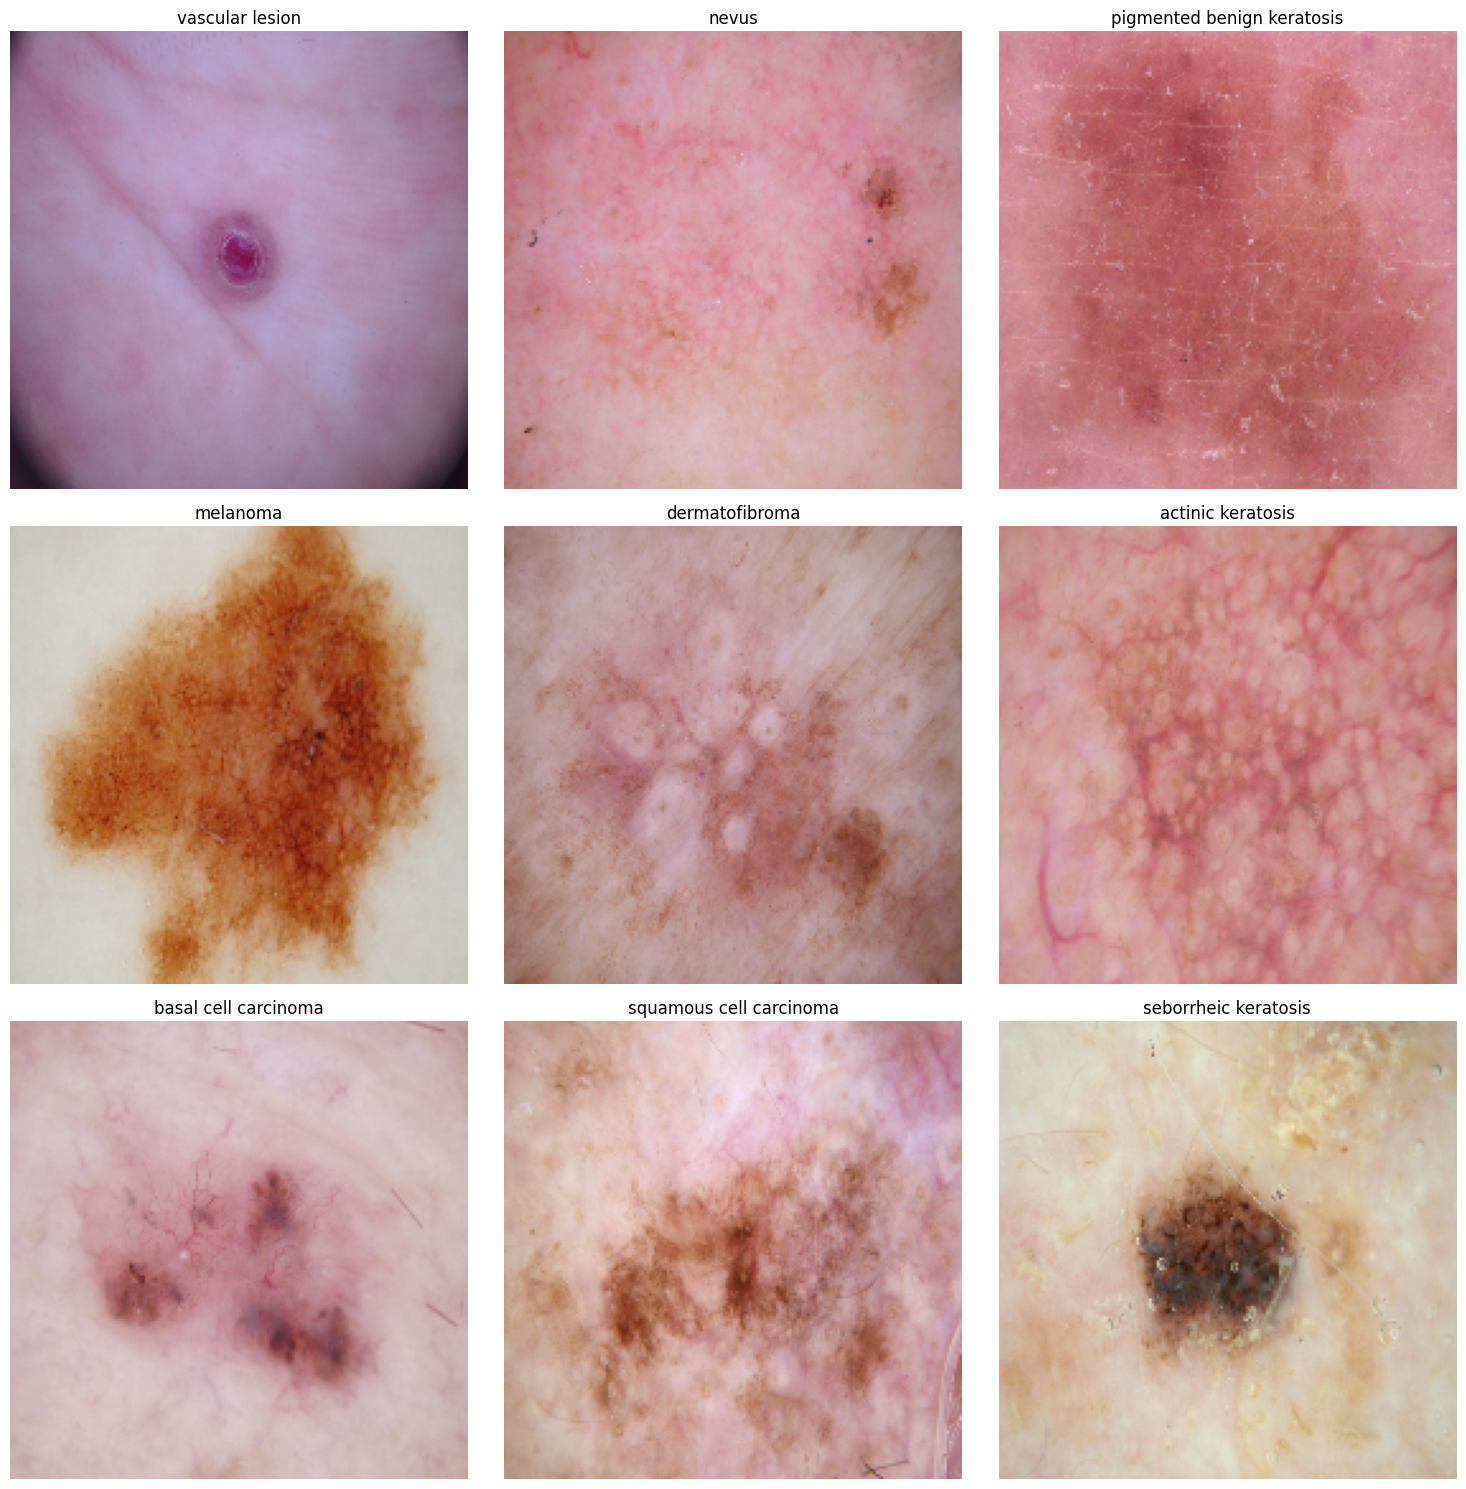

In [ ]:
import matplotlib.pyplot as plt

def visualize_class(dataset, class_names, num_classes = 9):
  plt.figure(figsize = (15,15))

  # Dictionary to store one example per class
  class_examples = {}

  # Iterate through the dataset to collect one example per class
  for images, labels in train_ds:
    for image, label in zip(images,labels):
      class_name = class_names[label.numpy()]
      if class_name not in class_examples:
        class_examples[class_name] = image
      if len(class_examples) == num_classes:
        break
    if len(class_examples) == num_classes:
      break

  # Plotting the examples
  for idx, (class_name, image) in enumerate(class_examples.items(),1):
    plt.subplot(3,3,idx)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
  plt.tight_layout()
  plt.show()

# Using Tranning Dataset
visualize_class(
    train_ds,
    class_names,
    num_classes=9
)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=9)))

In [ ]:
### Your code goes here
'''model = models.Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])'''

"model = models.Sequential([\n        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),\n        layers.Conv2D(32, (3, 3), activation='relu'),\n        layers.MaxPooling2D((2, 2)),\n        layers.Conv2D(64, (3, 3), activation='relu'),\n        layers.MaxPooling2D((2, 2)),\n        layers.Conv2D(128, (3, 3), activation='relu'),\n        layers.MaxPooling2D((2, 2)),\n        layers.Flatten(),\n        layers.Dense(128, activation='relu'),\n        layers.Dense(num_classes, activation='softmax')\n    ])"

The error you're encountering is due to the use of the experimental module, which is no longer available in recent versions of TensorFlow/Keras.

In [ ]:
model = models.Sequential([
    # Correct way to use the Rescaling layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values to [0, 1]
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(36, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax')  # Assuming 10 classes for classification
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 36)          │           5,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107584)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,885,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,912,493 (26.37 MB)

 Trainable params: 6,912,493 (26.37 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 36)          │           5,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107584)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,885,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,912,493 (26.37 MB)

 Trainable params: 6,912,493 (26.37 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.2603 - loss: 2.0982 - val_accuracy: 0.3982 - val_loss: 1.7240
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.4259 - loss: 1.6753 - val_accuracy: 0.4922 - val_loss: 1.4816
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4888 - loss: 1.4393 - val_accuracy: 0.4966 - val_loss: 1.4726
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5277 - loss: 1.3299 - val_accuracy: 0.4362 - val_loss: 1.6162
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5509 - loss: 1.2698 - val_accuracy: 0.5257 - val_loss: 1.4126
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5842 - loss: 1.1795 - val_accuracy: 0.4944 - val_loss: 1.4763
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5724 - loss: 1.1932 - val_accuracy: 0.5213 - val_loss: 1.4447
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6427 - loss: 1.0196 - val_accuracy: 0.5280 - 

### Visualizing training results

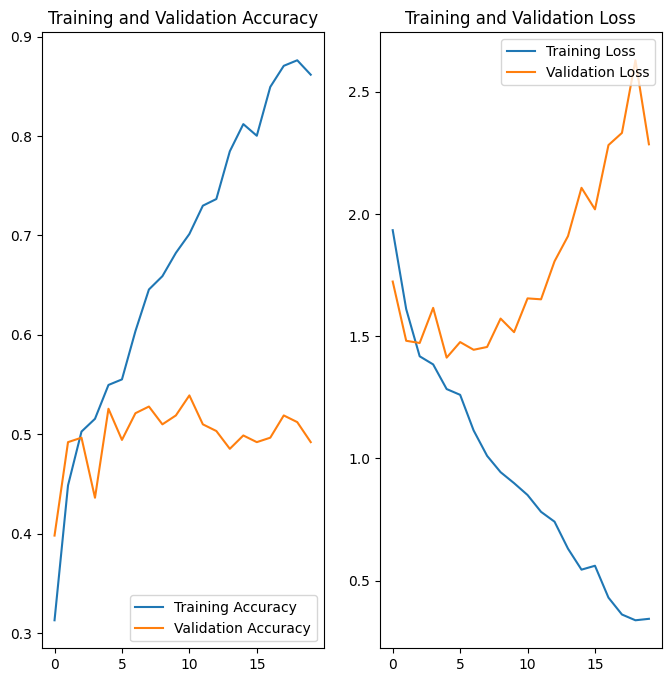

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The training accuracy continues to rise while the validation accuracy stagnates or even decreases.
The training loss decreases, but the validation loss increases towards the end, showing the model is overfitting the training data. It has learned patterns in the training data but fails to generalize to new, unseen data.

Conclusion: The model is overfitting due to memorizing the training data instead of learning generalizable features.

In [ ]:
# Define the augmentation model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Flip images horizontally
    layers.RandomRotation(0.2),       # Increase random rotation
    layers.RandomZoom(0.2),           # Increase random zoom
])

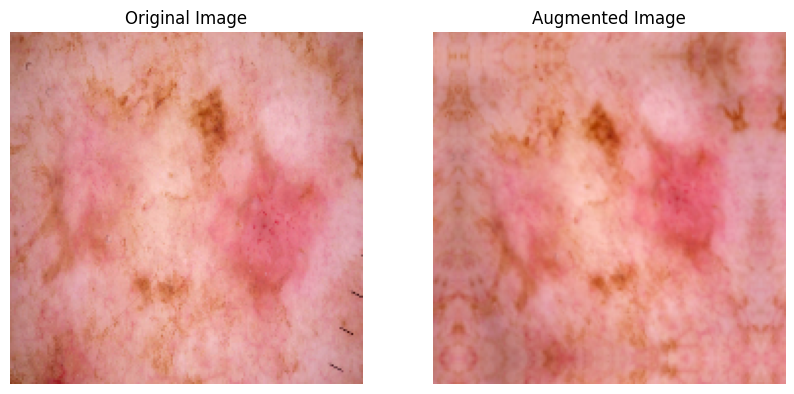

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images from the training dataset
for images, labels in train_ds.take(1):  # Take one batch
    sample_image = images[0].numpy()  # Convert Tensor to NumPy array

# Apply the augmentation model to the sample image
augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
augmented_image = augmented_image[0].numpy()  # Convert Tensor to NumPy array

# Ensure the images are scaled between 0 and 1
sample_image = sample_image - sample_image.min()
sample_image = sample_image / sample_image.max()

augmented_image = augmented_image - augmented_image.min()
augmented_image = augmented_image / augmented_image.max()

# Plot the original and augmented images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image)  # Ensure it's scaled correctly
plt.title("Original Image")
plt.axis('off')

# Augmented image
plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis('off')

plt.show()


In [ ]:
model = tf.keras.Sequential([
    data_augmentation,  # Apply augmentation before training
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9-class classification
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1855 - loss: 2.1918 - val_accuracy: 0.3065 - val_loss: 1.9169
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2918 - loss: 1.9206 - val_accuracy: 0.3937 - val_loss: 1.7318
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4008 - loss: 1.7237 - val_accuracy: 0.4586 - val_loss: 1.5983
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4098 - loss: 1.6638 - val_accuracy: 0.4720 - val_loss: 1.4972
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4903 - loss: 1.4814 - val_accuracy: 0.4810 - val_loss: 1.5189
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4890 - loss: 1.4531 - val_accuracy: 0.4810 - val_loss: 1.4715
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5133 - loss: 1.4139 - val_accuracy: 0.5056 - val_loss: 1.4205
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5156 - loss: 1.4110 - val_accuracy: 0.5302 - v

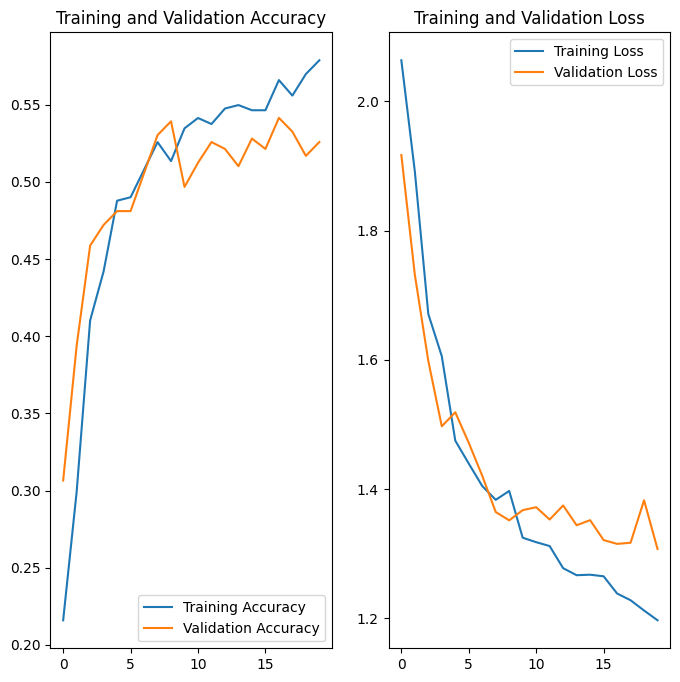

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = tf.keras.Sequential([
    data_augmentation,  # Apply augmentation before training
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9-class classification
])



### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
history3 = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.1824 - loss: 2.2982 - val_accuracy: 0.2908 - val_loss: 1.9750
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3026 - loss: 1.9117 - val_accuracy: 0.4295 - val_loss: 1.7593
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4214 - loss: 1.6986 - val_accuracy: 0.4206 - val_loss: 1.6265
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4198 - loss: 1.6184 - val_accuracy: 0.4698 - val_loss: 1.5410
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4471 - loss: 1.5053 - val_accuracy: 0.5168 - val_loss: 1.5586
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4734 - loss: 1.5008 - val_accuracy: 0.5034 - val_loss: 1.4469
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5031 - loss: 1.4195 - val_accuracy: 0.5078 - val_loss: 1.4638
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4945 - loss: 1.4053 - val_accuracy: 0.4877 - v

### Visualizing the results

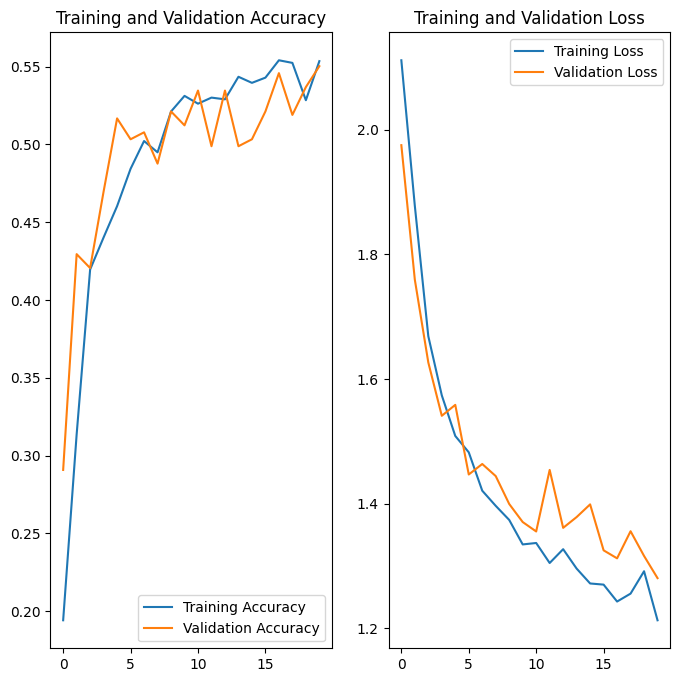

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model with dropout layers does seem to show better performance compared to the previous model without dropout. Although both models experienced fluctuations in accuracy and loss, adding dropout helped to stabilize the results and avoid a sharp overfitting trend seen in models with no regularization.

The validation accuracy is higher and more stable with the addition of dropout, though it still fluctuates. This indicates that dropout is having a positive effect on regularization but more fine-tuning may be needed for further improvement.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

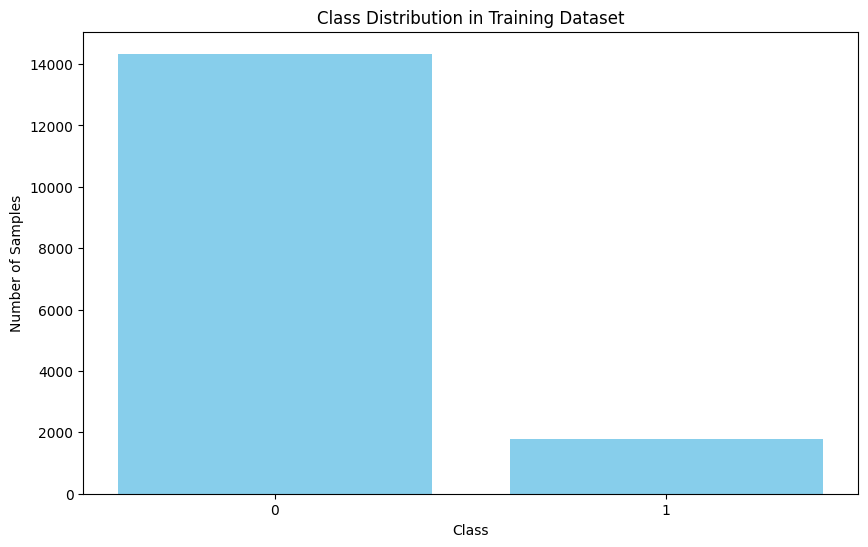

Class Distribution: {0.0: 14336, 1.0: 1792}


In [ ]:
# Assuming you have the train_dataset with labels available
class_labels = []

# Iterate through the training dataset and collect labels
for images, labels in train_ds:
    class_labels.extend(labels.numpy())

# Convert to numpy array and count the occurrences of each class
class_labels = np.array(class_labels)
unique, counts = np.unique(class_labels, return_counts=True)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(unique)
plt.show()

# Optionally, print the class distribution
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

#### - Class 1 has the least amount of samples
#### - Class 0 dominates the amount of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    p.process()

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF1D45B9D0>: 100%|██████████| 500/500 [00:24<00:00, 20.20 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF0026B2D0>: 100%|██████████| 114/114 [00:06<00:00, 18.57 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF0078BA10>: 100%|██████████| 500/500 [00:19<00:00, 25.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF002998D0>: 100%|██████████| 376/376 [00:14<00:00, 26.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF004CB510>: 100%|██████████| 500/500 [00:18<00:00, 26.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF184C2D90>: 100%|██████████| 95/95 [00:03<00:00, 28.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x7FDF00267250>: 100%|██████████| 500/500 [01:20<00:00,  6.25 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDF003DA750>: 100%|██████████| 438/438 [01:14<00:00,  5.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FDF19D51CD0>: 100%|██████████| 500/500 [01:15<00:00,  6.65 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF005EA8D0>: 100%|██████████| 357/357 [00:56<00:00,  6.29 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF0069CED0>: 100%|██████████| 500/500 [00:18<00:00, 26.36 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF05F35990>: 100%|██████████| 462/462 [00:18<00:00, 24.61 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDF18325D50>: 100%|██████████| 500/500 [00:42<00:00, 11.83 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDF0028B310>: 100%|██████████| 77/77 [00:05<00:00, 13.39 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDF18327B10>: 100%|██████████| 500/500 [00:18<00:00, 27.46 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF0029C150>: 100%|██████████| 181/181 [00:07<00:00, 22.89 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF18474950>: 100%|██████████| 500/500 [00:18<00:00, 27.20 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF007632D0>: 100%|██████████| 139/139 [00:06<00:00, 21.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6739


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
original_df = pd.DataFrame(columns=['Path', 'Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8978 files belonging to 9 classes.
Using 7183 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8978 files belonging to 9 classes.
Using 1795 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
model = tf.keras.Sequential([
    # Data Augmentation
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # Conv Block 1
    layers.Conv2D(16, (3, 3), activation='relu', padding="same"),
    layers.MaxPooling2D(2, 2),

    # Conv Block 2
    layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),  # Dropout only if overfitting is seen

    # Conv Block 3
    layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9-class classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [7]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Model Summary
model.summary()

NameError: name 'model' is not defined

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history4 = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    shuffle=True
)


Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 61s 244ms/step - accuracy: 0.1806 - loss: 2.1242 - val_accuracy: 0.3120 - val_loss: 1.8787
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 63s 281ms/step - accuracy: 0.3379 - loss: 1.7351 - val_accuracy: 0.3593 - val_loss: 1.6958
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - accuracy: 0.3991 - loss: 1.6326 - val_accuracy: 0.4100 - val_loss: 1.6008
Epoch 4/30
192/225 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.4227 - loss: 1.5554

#### **Todo:**  Visualize the model results

In [ ]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

